In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn --user
abs_dir="/mnt/data/mranzini"
# abs_dir="/Users/Marta/Desktop/mountpoint"
sys.path.append(os.path.join(*[abs_dir, "Code", "Demic-v0.1"]))
import pandas as pd
from Demic.util.image_process import *
# from Demic.image_io.file_read_write import *

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def compute_IoU(seg1, seg2, label=1.0, display_counters=False):
    """
    computes intersection over union as TP/(TP + FP + FN)
    inputs
        - seg1: first segmentation mask 
        - seg2: second segmentation mask to compare to first
        - label: which label to compute the iou for
    output:
        - iou: intersection over union
    """

    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = (seg1 == label)
    yp = (seg2 == label)

    TP = np.sum(np.logical_and(yt == 1, yp == 1))  # True positives
    TN = np.sum(np.logical_and(yt == 0, yp == 0))  # True negatives
    FP = np.sum(np.logical_and(yt == 0, yp == 1))  # False positives
    FN = np.sum(np.logical_and(yt == 1, yp == 0))  # False negatives
    
    iou = TP / (TP + FP + FN)
    
    if display_counters:
        print('TP = ' + str(TP))
        print('TN = ' + str(TN))
        print('FP = ' + str(FP))
        print('FN = ' + str(FN))
        print('IoU = ' + str(iou))

    return iou

In [3]:
# Guotai's implementation
def binary_iou(s, g):
    assert(len(s.shape)== len(g.shape))
    intersecion = np.multiply(s, g)
    union = np.asarray(s + g >0, np.float32)
    iou = intersecion.sum()/(union.sum() + 1e-10)
    return iou


In [4]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice 

In [5]:
# quick test iou makes sense
A = np.array([[1, 2, 2, 1], [2, 2, 2, 1], [4, 5, 2, 1], [8, 2, 4, 2]])
# print(A)
B = np.array([[2, 2, 2, 2], [1, 1, 1, 1], [1, 2, 2, 1], [8, 2, 2, 2]])
# print(B)

# for class = 2
# expected: TP = 5; TN = 4; FP = 4; FN = 3; => IoU = 0.41666667
IoU = compute_IoU(A, B, label=2, display_counters=True)
IoU_guotai = binary_iou(s=(A==2), g=(B==2))
print(IoU_guotai)

dice = compute_dice(A, B, label=2)
# expected: 10/17 = 0.588 
print(dice)

TP = 5
TN = 4
FP = 4
FN = 3
IoU = 0.4166666666666667
0.41666666666319446
0.588235294114187


In [6]:
def percentage_dice_per_slice(seg1, seg2, dice_thr=0.9):
    """
    Computes the percentage of slices that have Dice score > dice_thr
    inputs
        - seg1: first segmentation mask, considered as ground truth
        - seg2: second segmentation mask to compare to first
        - label: which label to compute the dice score for
    output:
        - percentage: percentage of slices with dice above the threshold
    NOTE: it expects the slicing to happen along the first dimension (as read by SimpleITK)
    """
    nr_slices = np.shape(seg1)[0]
    all_slices_dice = np.empty(nr_slices)
    for i in range(0, nr_slices):
        temp_seg1 = seg1[i, ...]
        temp_seg2 = seg2[i, ...]
        
        # if the foreground segmentation is empty in the GT, compute the the Dice for the background
        if np.all(temp_seg1 == 0.0):
            all_slices_dice[i] = compute_dice(temp_seg1, temp_seg2, label=0.0)
        # else consider the dice of the foreground
        else:
            all_slices_dice[i] = compute_dice(temp_seg1, temp_seg2, label=1.0)
                
    # compute the percentage of slices with dice above the threshold
    nr_good_slices = np.count_nonzero(all_slices_dice >= dice_thr)
    percentage = 100 *  nr_good_slices / nr_slices
#     print(f"Nr slices >= {dice_thr}: {nr_good_slices}/{nr_slices} - {percentage}%")
    
    return percentage    

In [7]:
# quick test to make sure the percentage dice per slice is computed correctly
A = np.ones((3, 4, 4))
B = np.zeros((3, 4, 4))

expected_0 = percentage_dice_per_slice(A, B)
print(f"Test 1: Expected percentage = 0, Obtained = {expected_0}")

A[2, :, :] = 0
expected_33 = percentage_dice_per_slice(A, B)
print(f"Test 2: Expected percentage = 33%, Obtained = {expected_33}")

A[1:2, :, :] = 1
B[1:2, :, :] = 1
expected_66 = percentage_dice_per_slice(A, B)
print(f"Test 3: Expected percentage = 66%, Obtained = {expected_66}")

Test 1: Expected percentage = 0, Obtained = 0.0
Test 2: Expected percentage = 33%, Obtained = 33.333333333333336
Test 3: Expected percentage = 66%, Obtained = 66.66666666666667


In [8]:
def compute_accuracy(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = (seg1 == label)
    yp = (seg2 == label)

    TP = np.sum(np.logical_and(yt == 1, yp == 1))  # True positives
    TN = np.sum(np.logical_and(yt == 0, yp == 0))  # True negatives
    FP = np.sum(np.logical_and(yt == 0, yp == 1))  # False positives
    FN = np.sum(np.logical_and(yt == 1, yp == 0))  # False negatives
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
def percentage_dice(seg1, seg2, dice_thr=0.9, bg_thr=0.9999, nr_min_pixels=40):
    """
    Compute the percentage of good slices only on the foreground 
    """
    nr_slices = np.shape(seg1)[0]
    all_slices = []
    slices_counter = 0
    for i in range(0, nr_slices):
        temp_seg1 = seg1[i, ...]
        temp_seg2 = seg2[i, ...]
        
        if np.sum(temp_seg1) > nr_min_pixels:
            dice = compute_dice(temp_seg1, temp_seg2, label=1.0)
            all_slices.append(1 if dice >= dice_thr else 0)
            slices_counter += 1
            
    # compute the percentage of slices with dice above the threshold
    all_slices = np.asarray(all_slices)
    nr_good_slices = np.count_nonzero(all_slices)
    percentage = nr_good_slices / slices_counter
    
    return percentage

def percentage_accuracy(seg1, seg2, dice_thr=0.9, bg_thr=0.9999, nr_min_pixels=40):
    """
    Compute the percentage of good slices only on the background (check for false positives)
    """
    nr_slices = np.shape(seg1)[0]
    all_slices = []
    slices_counter = 0
    for i in range(0, nr_slices):
        temp_seg1 = seg1[i, ...]
        temp_seg2 = seg2[i, ...]
        
        # if the foreground segmentation is empty in the GT, or very little foregroun
        # compute the the Dice for the background
        if np.all(temp_seg1 == 0) or np.sum(temp_seg1) <= nr_min_pixels:
            accuracy = compute_dice(temp_seg1, temp_seg2, label=0.0)
            all_slices.append(1 if accuracy >= bg_thr else 0)
            slices_counter += 1
            
    # compute the percentage of slices with accuracy above the threshold
    all_slices = np.asarray(all_slices)
    nr_good_slices = np.count_nonzero(all_slices)
    if slices_counter != 0:
        percentage = nr_good_slices / slices_counter
    else:
        percentage = 1.0
    
    return percentage

def percentage_dice_and_accuracy(seg1, seg2, dice_thr=0.9, bg_thr=0.9999, nr_min_pixels=40):
    """
    Combine foreground and background metrics into one
    """
    nr_slices = np.shape(seg1)[0]
    all_slices = np.empty(nr_slices)
    for i in range(0, nr_slices):
        temp_seg1 = seg1[i, ...]
        temp_seg2 = seg2[i, ...]
        
        # if the foreground segmentation is empty in the GT, or very little foregroun
        # compute the the Dice for the background
        if np.all(temp_seg1 == 0) or np.sum(temp_seg1) <= nr_min_pixels:
            accuracy = compute_dice(temp_seg1, temp_seg2, label=0.0)
#             print(f"accuracy = {accuracy}")
            all_slices[i] = 1 if accuracy >= bg_thr else 0
        # else consider the dice of the foreground
        else:
            dice = compute_dice(temp_seg1, temp_seg2, label=1.0)
#             print(f"dice = {dice}")
            all_slices[i] = 1 if dice >= dice_thr else 0
            
    # compute the percentage of slices with dice above the threshold
    nr_good_slices = np.count_nonzero(all_slices)
    percentage = 100 *  nr_good_slices / nr_slices
    
    return percentage

In [9]:
# quick test to make sure the percentage dice per slice is computed correctly
A = np.ones((3, 4, 4))
B = np.zeros((3, 4, 4))

expected_0 = percentage_dice_and_accuracy(A, B, nr_min_pixels=4)
print(f"Test 1: Expected percentage = 0, Obtained = {expected_0}\n")

A[2, :, :] = 0
expected_33 = percentage_dice_and_accuracy(A, B, nr_min_pixels=4)
print(f"Test 2: Expected percentage = 33%, Obtained = {expected_33}\n")

A[1:, :, :] = 1
B[1:, :, :] = 1
expected_66 = percentage_dice_and_accuracy(A, B, nr_min_pixels=4)
print(f"Test 3: Expected percentage = 66%, Obtained = {expected_66}\n")

A[1, 0:, 0:3] = 0
expected_33 = percentage_dice_and_accuracy(A, B, nr_min_pixels=4)
print(f"Test 4: Expected percentage = 33%, Obtained = {expected_33}\n")

B[1, 1:, 0:3] = 0
expected_33 = percentage_dice_and_accuracy(A, B, bg_thr=0.8, nr_min_pixels=4)
print(f"Test 5: Expected percentage = 66%, Obtained = {expected_66}\n")

Test 1: Expected percentage = 0, Obtained = 0.0

Test 2: Expected percentage = 33%, Obtained = 33.333333333333336

Test 3: Expected percentage = 66%, Obtained = 66.66666666666667

Test 4: Expected percentage = 33%, Obtained = 33.333333333333336

Test 5: Expected percentage = 66%, Obtained = 66.66666666666667



In [10]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [11]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img

In [12]:
def apply_post_processing(input_pred, pred_thr=0.5):
    
    strt = ndimage.generate_binary_structure(3,2) # iterate structure
    input_pred = input_pred > pred_thr   # TODO: check that this step is actually needed - Guotai did not have but need to check what activation he had in final layer
    post_mask = ndimage.morphology.binary_closing(input_pred, strt)
    post_mask = get_largest_component(post_mask)
    postprocessed = np.asarray(post_mask*input_pred, np.uint8)

    return postprocessed

In [13]:
def get_all_dice(group="GroupA", remove_outliers=False, metric=compute_dice):

    MAIN_DIR = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Retraining_with_expanded_dataset"])
    folder_segment_guotai = os.path.join(*[MAIN_DIR, "inference", "guotai"])
    folder_segment_retrained = os.path.join(*[MAIN_DIR, "inference", "expanded"])
    folder_unet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                            "basic_unet_monai", "tests_deterministic_seeds", "monai0.2.0_tests",
                             "2020-09-22_15-50-00_monai0.2.0-MONAI_unet-Batch_Dice_Xent_two_channel_inplanecrop", 
                             "inference_valid_key_metric=0.9504"])
    folder_dynUnet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "test_monaifbs", "inference_with_final_model", "inference_valid_key_metric=0.9491"])
    folder_nnUnet = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "FBS_Monai",
                                "basic_unet_monai", "tests_deterministic_seeds", "nnUNet_comparison",
                                "nnUNet_UniformSampling_pred_test"])
    
    folder_gt1 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset"])
    folder_gt2 = os.path.join(*[abs_dir, "Desktop", "GIFT-Surg", "Data", "NeuroImage_dataset_extension"])

    params_dict = {'GroupA': os.path.join(folder_gt1, "list_inference_h_subjects.txt"),
                  'GroupB1': os.path.join(folder_gt1, "list_inference_p1_subjects.txt"),
                  'GroupB2': os.path.join(folder_gt1, "list_inference_p2_subjects.txt"),
                  'GroupC': os.path.join(*[folder_gt2, "splitting_list", "list_inference_C.txt"]),
                  'GroupD': os.path.join(*[folder_gt2, "splitting_list", "list_inference_D.txt"]),
                  'GroupE': os.path.join(*[folder_gt2, "splitting_list", "list_inference_E.txt"]),
                  'GroupF': os.path.join(*[folder_gt2, "splitting_list", "list_inference_F.txt"])
                  }
    
    gt_dict = {'GroupA': folder_gt1,
               'GroupB1': folder_gt1,
               'GroupB2': folder_gt1,
               'GroupC': folder_gt2,
               'GroupD': folder_gt2,
               'GroupE': folder_gt2,
               'GroupF': folder_gt2}

    dice_vals = {"subj_id": [], "guotai": [], "expanded": [], "basic_unet": [], 
                 "dynUnet": [], "nnU-Net": []}
    subj_list = params_dict[group]
    folder_gt = gt_dict[group]
    with open(subj_list) as r:
        lines = r.readlines()
        for l in lines:
            print(l)
            all_stacks = sorted(glob.glob(os.path.join(*[folder_gt, group, l.rstrip() + '*_Label.nii.gz'])))
            for s in all_stacks:
                scan_id = os.path.basename(s)
                scan_id = scan_id.split("_Label", 1)[0]
                if scan_id == "b79_16":
                    # original image is corrupted
                    continue
                dice_vals["subj_id"].append(scan_id)
                
                # get the ground truth
                gt = np.squeeze(read_nifti(s))
                
                # extract dice from Guotai's model
                guotai_file = os.path.join(*[folder_segment_guotai, group, scan_id + "_segment.nii.gz"])
                guotai_segment = np.squeeze(read_nifti(guotai_file))
                # always apply post-processing for guotai's models
                guotai_segment = apply_post_processing(guotai_segment)
                dice_vals["guotai"].append(metric(gt, guotai_segment))
                
                # extract dice from expanded training model
                retrained_file = os.path.join(*[folder_segment_retrained, group, scan_id + "_segment.nii.gz"])
                retrained_segment = np.squeeze(read_nifti(retrained_file))
                # always apply post-processing for guotai's models
                retrained_segment = apply_post_processing(retrained_segment)
                dice_vals["expanded"].append(metric(gt, retrained_segment))
                
#                 # extract dice from basic unet in monai
#                 monai_file = os.path.join(*[folder_unet, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
#                 monai_segment = np.squeeze(read_nifti(monai_file))
#                 if(remove_outliers):
#                     monai_segment = apply_post_processing(monai_segment)
#                 monai_segment = monai_segment > 0.05
#                 dice_vals["basic_unet"].append(metric(gt, monai_segment))
                
                # extract dice from dynUnet in monai
                monai_dyn_file = os.path.join(*[folder_dynUnet, scan_id + "_Image", scan_id + "_Image_seg.nii.gz"])
                monai_dyn_segment = np.squeeze(read_nifti(monai_dyn_file))
                # no need to apply post-processing as applied at inference directly
                # monai_dyn_segment = monai_dyn_segment > 0.05
                dice_vals["dynUnet"].append(metric(gt, monai_dyn_segment))
                                
#                 # extract dice from nnUNet
#                 nnunet_file = os.path.join(*[folder_nnUnet, group + "_" + scan_id + "_Image.nii.gz"])
#                 nnunet_segment = np.squeeze(read_nifti(nnunet_file))
#                 if(remove_outliers):
#                     nnunet_segment = apply_post_processing(nnunet_segment)
#                 nnunet_segment = nnunet_segment > 0.05
#                 dice_vals["nnU-Net"].append(metric(gt, nnunet_segment))

    dice_vals["guotai"] = np.asarray(dice_vals["guotai"])
    dice_vals["expanded"] = np.asarray(dice_vals["expanded"])
    dice_vals["basic_unet"] = np.asarray(dice_vals["basic_unet"])
    dice_vals["dynUnet"] = np.asarray(dice_vals["dynUnet"])
    dice_vals["nnU-Net"] = np.asarray(dice_vals["nnU-Net"])

    return dice_vals

In [14]:
remove_outlier = True
# metric = percentage_dice_per_slice
# metric = percentage_dice_and_accuracy
# ylabel = "% of accepted slices"
# fig_title = "FG Dice>=0.9, BG acc >=0.999"
metric = compute_dice
# metric = percentage_accuracy


dice_groupA = get_all_dice(group="GroupA", remove_outliers=remove_outlier, metric=metric)
dice_groupB1 = get_all_dice(group="GroupB1", remove_outliers=remove_outlier, metric=metric)
dice_groupB2 = get_all_dice(group="GroupB2", remove_outliers=remove_outlier, metric=metric)
dice_groupC = get_all_dice(group="GroupC", remove_outliers=remove_outlier, metric=metric)
dice_groupD = get_all_dice(group="GroupD", remove_outliers=remove_outlier, metric=metric)
dice_groupE = get_all_dice(group="GroupE", remove_outliers=remove_outlier, metric=metric)
dice_groupF = get_all_dice(group="GroupF", remove_outliers=remove_outlier, metric=metric)

a02

a06

a17

a24

a26

b18

b79

17_05

17_10

17_14

17_16

17_18

17_20

17_25

17_34

17_36

17_38

17_43

17_49

17_51

17_53

17_57

17_66

17_06

17_11

17_15

17_17

17_19

17_21

17_26

17_35

17_37

17_39

17_44

17_50

17_52

17_54

17_58

17_67

C01

C07

C08

C17

C22

D01

D05

E07

E08

E16

E17

F01

F02

F03

F04



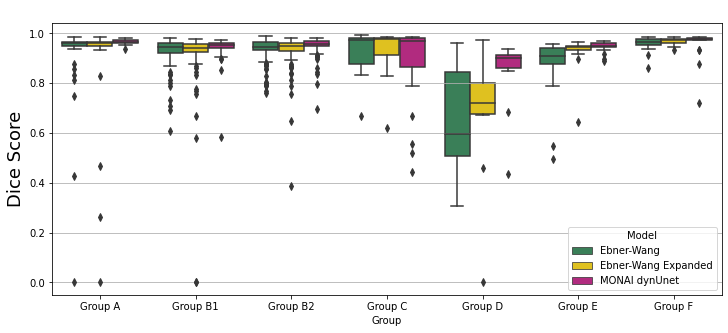

In [15]:
import pandas as pd
ylabel = "Dice Score"
fig_title = " "

pd1 = pd.DataFrame(data={'Group': 'Group A', 'Dice': dice_groupA['guotai'], 'Model': 'Ebner-Wang'})
pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['guotai'], 'Model': 'Ebner-Wang'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['guotai'], 'Model': 'Ebner-Wang'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['guotai'], 'Model': 'Ebner-Wang'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['guotai'], 'Model': 'Ebner-Wang'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['guotai'], 'Model': 'Ebner-Wang'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['guotai'], 'Model': 'Ebner-Wang'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['expanded'], 'Model': 'Ebner-Wang Expanded'}))

# pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['basic_unet'], 'Model': 'MONAI Unet'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['basic_unet'], 'Model': 'MONAI Unet'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['basic_unet'], 'Model': 'MONAI Unet'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['basic_unet'], 'Model': 'MONAI Unet'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['basic_unet'], 'Model': 'MONAI Unet'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['basic_unet'], 'Model': 'MONAI Unet'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['basic_unet'], 'Model': 'MONAI Unet'}))

pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['dynUnet'], 'Model': 'MONAI dynUnet'}))

# pd1 = pd1.append(pd.DataFrame({'Group': 'Group A', 'Dice': dice_groupA['nnU-Net'], 'Model': 'nnU-Net'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group B1', 'Dice': dice_groupB1['nnU-Net'], 'Model': 'nnU-Net'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group B2', 'Dice': dice_groupB2['nnU-Net'], 'Model': 'nnU-Net'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group C', 'Dice': dice_groupC['nnU-Net'], 'Model': 'nnU-Net'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group D', 'Dice': dice_groupD['nnU-Net'], 'Model': 'nnU-Net'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group E', 'Dice': dice_groupE['nnU-Net'], 'Model': 'nnU-Net'}))
# pd1 = pd1.append(pd.DataFrame({'Group': 'Group F', 'Dice': dice_groupF['nnU-Net'], 'Model': 'nnU-Net'}))

fig = plt.figure(figsize=(12, 5))
# b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, 
#                  palette=['seagreen', 'gold', 'orangered', 'mediumvioletred', 'mediumpurple', 'lightblue'])
# b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, 
#                  palette=['seagreen', 'gold', 'mediumvioletred', 'mediumpurple', 'lightblue'])
b1 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd1, 
                 palette=['seagreen', 'gold', 'mediumvioletred'])
b1.set_ylabel(ylabel, fontsize=18)
b1.set_title(fig_title)
plt.grid(b=True,axis='y')

[None, None, None, None, None, None]

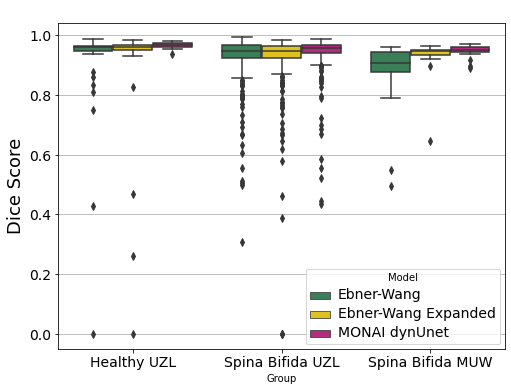

In [28]:
pd2 = pd.DataFrame(data={'Group': 'Healthy UZL', 'Dice': dice_groupA['guotai'], 'Model': 'Ebner-Wang'})
pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['guotai'], 'Model': 'Ebner-Wang'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['guotai'], 'Model': 'Ebner-Wang'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['guotai'], 'Model': 'Ebner-Wang'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['guotai'], 'Model': 'Ebner-Wang'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida MUW', 'Dice': dice_groupE['guotai'], 'Model': 'Ebner-Wang'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida MUW', 'Dice': dice_groupE['expanded'], 'Model': 'Ebner-Wang Expanded'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupF['guotai'], 'Model': 'Ebner-Wang'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupF['expanded'], 'Model': 'Ebner-Wang Expanded'}))

# pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['basic_unet'], 'Model': 'MONAI Unet'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['basic_unet'], 'Model': 'MONAI Unet'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['basic_unet'], 'Model': 'MONAI Unet'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['basic_unet'], 'Model': 'MONAI Unet'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['basic_unet'], 'Model': 'MONAI Unet'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['basic_unet'], 'Model': 'MONAI Unet'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupF['basic_unet'], 'Model': 'MONAI Unet'}))

pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida MUW', 'Dice': dice_groupE['dynUnet'], 'Model': 'MONAI dynUnet'}))
pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupF['dynUnet'], 'Model': 'MONAI dynUnet'}))

# pd2 = pd2.append(pd.DataFrame({'Group': 'Healthy UZL', 'Dice': dice_groupA['nnU-Net'], 'Model': 'nnU-Net'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB1['nnU-Net'], 'Model': 'nnU-Net'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupB2['nnU-Net'], 'Model': 'nnU-Net'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupC['nnU-Net'], 'Model': 'nnU-Net'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupD['nnU-Net'], 'Model': 'nnU-Net'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida Vienna', 'Dice': dice_groupE['nnU-Net'], 'Model': 'nnU-Net'}))
# pd2 = pd2.append(pd.DataFrame({'Group': 'Spina Bifida UZL', 'Dice': dice_groupF['nnU-Net'], 'Model': 'nnU-Net'}))

fig2 = plt.figure(figsize=(8, 6))
# b2 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd2, 
#                  palette=['seagreen', 'gold', 'mediumvioletred', 'mediumpurple', 'lightblue'])
b2 = sns.boxplot(x='Group', y='Dice', hue='Model', data=pd2, 
                 palette=['seagreen', 'gold', 'mediumvioletred'])
b2.set_ylabel(ylabel, fontsize=18)
# b2.set_ylim([0.5, 1.05])
b2.set_title(fig_title)
b2.tick_params(labelsize=14)
plt.grid(b=True,axis='y')
plt.setp(b2.get_legend().get_texts(), fontsize='14')

Ebner-Wang
68
Ebner-Wang Expanded
53
MONAI dynUnet
28


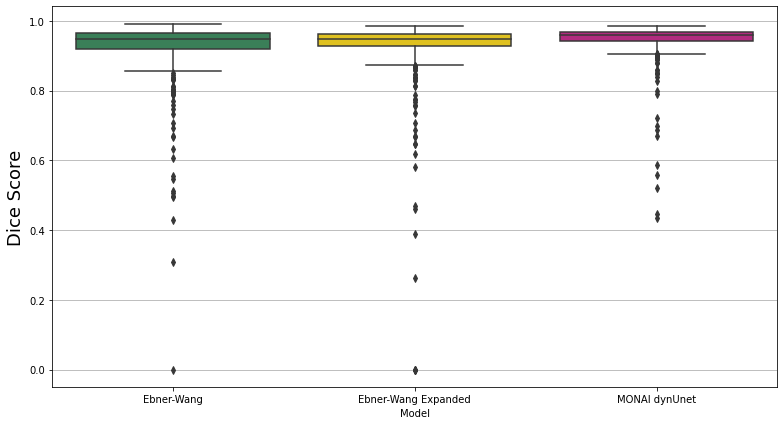

In [17]:
# boxplot overall
def append_all_data(which_key):
    all_dices = np.concatenate((dice_groupA[which_key],
                               dice_groupB1[which_key],
                               dice_groupB2[which_key],
                               dice_groupC[which_key],
                               dice_groupD[which_key],
                               dice_groupE[which_key],
                               dice_groupF[which_key]))
    return all_dices
    
pd3 = pd.DataFrame(data={'Model': 'Ebner-Wang', 'Dice': append_all_data('guotai')})
pd3 = pd3.append(pd.DataFrame(data={'Model': 'Ebner-Wang Expanded', 'Dice': append_all_data('expanded')}))
# pd3 = pd3.append(pd.DataFrame(data={'Model': 'MONAI Unet', 'Dice': append_all_data('basic_unet')}))
pd3 = pd3.append(pd.DataFrame(data={'Model': 'MONAI dynUnet', 'Dice': append_all_data('dynUnet')}))
# pd3 = pd3.append(pd.DataFrame(data={'Model': 'nnU-Net', 'Dice': append_all_data('nnU-Net')}))

fig3 = plt.figure(figsize=(13, 7))
# b3 = sns.boxplot(x='Model', y='Dice', data=pd3, 
#                  palette=['seagreen', 'gold', 'mediumvioletred', 'mediumpurple', 'lightblue'])
b3 = sns.boxplot(x='Model', y='Dice', data=pd3, 
                 palette=['seagreen', 'gold', 'mediumvioletred'])
b3.set_ylabel(ylabel, fontsize=18)
plt.grid(b=True,axis='y')

# print indexes of all Dices lower than 0.9
thr_ = 0.9
for k in ['Ebner-Wang', 'Ebner-Wang Expanded', 'MONAI dynUnet']:
    print(k)
    tmp_pd = pd3[pd3['Model'] == k]
    idx_dice = tmp_pd[tmp_pd['Dice'] <= thr_].index
    print(len(list(idx_dice)))

In [18]:
thr = 70
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch',  'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupA[k] <= thr), axis=-1)
    print([dice_groupA['subj_id'][i] for i in idx])


guotai
['a02_02', 'a02_03', 'a02_04', 'a02_07', 'a02_08', 'a02_09', 'a06_03', 'a06_04', 'a06_05', 'a06_06', 'a06_07', 'a17_07', 'a17_08', 'a17_09', 'a17_10', 'a17_15', 'a17_16', 'a17_21', 'a24_09', 'a24_10', 'a24_11', 'a24_12', 'a24_14', 'a24_16', 'a24_17', 'a24_19', 'a24_20', 'a26_02', 'a26_03', 'a26_05', 'a26_06', 'a26_08', 'a26_09', 'a26_11', 'a26_12', 'b18_29', 'b18_30', 'b18_31', 'b18_32', 'b79_10', 'b79_12', 'b79_13', 'b79_15']
expanded
['a02_02', 'a02_03', 'a02_04', 'a02_07', 'a02_08', 'a02_09', 'a06_03', 'a06_04', 'a06_05', 'a06_06', 'a06_07', 'a17_07', 'a17_08', 'a17_09', 'a17_10', 'a17_15', 'a17_16', 'a17_21', 'a24_09', 'a24_10', 'a24_11', 'a24_12', 'a24_14', 'a24_16', 'a24_17', 'a24_19', 'a24_20', 'a26_02', 'a26_03', 'a26_05', 'a26_06', 'a26_08', 'a26_09', 'a26_11', 'a26_12', 'b18_29', 'b18_30', 'b18_31', 'b18_32', 'b79_10', 'b79_12', 'b79_13', 'b79_15']
dynUnet
['a02_02', 'a02_03', 'a02_04', 'a02_07', 'a02_08', 'a02_09', 'a06_03', 'a06_04', 'a06_05', 'a06_06', 'a06_07', 'a1

KeyError: 'dynUnet_batch'

In [ ]:
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch', 'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupB1[k] <=thr), axis=-1)
    print([dice_groupB1['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch', 'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupB2[k] <= thr), axis=-1)
    print([dice_groupB2['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch', 'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupC[k] <= thr), axis=-1)
    print([dice_groupC['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch', 'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupD[k] <= thr), axis=-1)
    print([dice_groupD['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch', 'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupE[k] <= thr), axis=-1)
    print([dice_groupE['subj_id'][i] for i in idx])

In [ ]:
for k in ['guotai', 'expanded', 'dynUnet', 'dynUnet_batch', 'basic_unet', 'nnU-Net']:
    print(k)
    idx = np.squeeze(np.argwhere(dice_groupF[k] <= thr), axis=-1)
    print([dice_groupF['subj_id'][i] for i in idx])